# DODAG Simplicado

O código a seguir apresenta um protótipo simplicado com objetivo de compreender como é realizada a construção da rede com topologia DODAG no protocolo RPL. Sendo assim, implementamos o cenário básico com as seguintes características:

- Nós com IDs úniicos e posições fixas.

- Raiz que envia DIOs para formar o DODAG.

- Os nós calculam o Rank e escolhem pais ao receber mensagens DIO.

- Baseado na métrica de número de saltos (hop count).

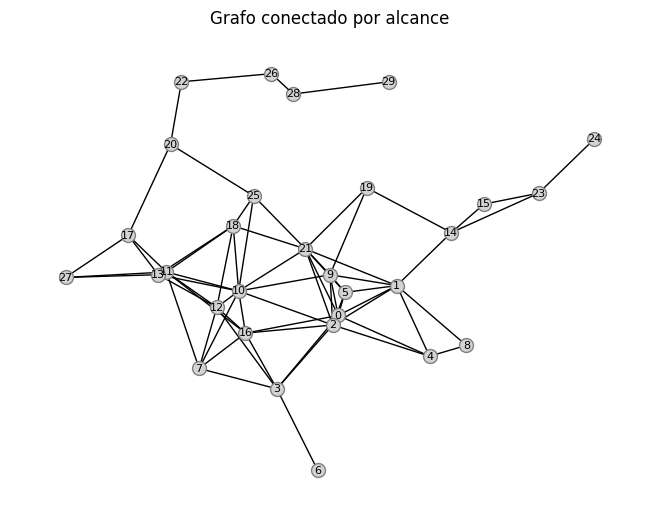

Nó 1 atualizou seu Rank para 1 (Pai: 0)
Nó 2 atualizou seu Rank para 1 (Pai: 0)
Nó 3 atualizou seu Rank para 1 (Pai: 0)
Nó 4 atualizou seu Rank para 1 (Pai: 0)
Nó 5 atualizou seu Rank para 1 (Pai: 0)
Nó 9 atualizou seu Rank para 1 (Pai: 0)
Nó 16 atualizou seu Rank para 1 (Pai: 0)
Nó 21 atualizou seu Rank para 1 (Pai: 0)
Nó 8 atualizou seu Rank para 2 (Pai: 1)
Nó 14 atualizou seu Rank para 2 (Pai: 1)
Nó 10 atualizou seu Rank para 2 (Pai: 2)
Nó 6 atualizou seu Rank para 2 (Pai: 3)
Nó 7 atualizou seu Rank para 2 (Pai: 3)
Nó 12 atualizou seu Rank para 2 (Pai: 3)
Nó 8 com Rank 2 adicionou (Pai: 4)
Nó 10 com Rank 2 adicionou (Pai: 9)
Nó 19 atualizou seu Rank para 2 (Pai: 9)
Nó 7 com Rank 2 adicionou (Pai: 16)
Nó 10 com Rank 2 adicionou (Pai: 16)
Nó 11 atualizou seu Rank para 2 (Pai: 16)
Nó 12 com Rank 2 adicionou (Pai: 16)
Nó 10 com Rank 2 adicionou (Pai: 21)
Nó 18 atualizou seu Rank para 2 (Pai: 21)
Nó 19 com Rank 2 adicionou (Pai: 21)
Nó 25 atualizou seu Rank para 2 (Pai: 21)
Nó 15 atualiz

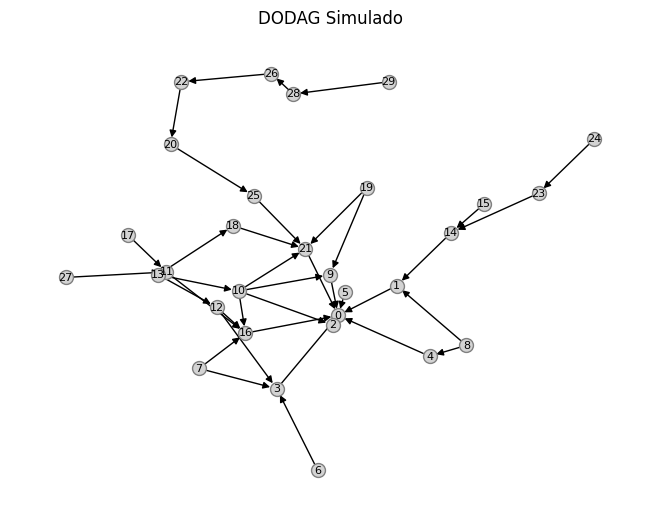

In [27]:
import random
import networkx as nx
import matplotlib.pyplot as plt

class Node:
    def __init__(self, node_id: int, position: tuple[float, float], is_root: bool = False):
        self.node_id: int = node_id
        self.position: tuple[float, float] = position
        self.is_root: bool = is_root
        self.rank: int = 0 if is_root else float('inf')  # Rank inicial (0 para a raiz)
        self.parents: list[Node] = []
        self.neighbors: list[Node] = []

    def receive_dio(self, sender: 'Node') -> None:
        """Processa uma mensagem DIO de um vizinho."""
        new_rank: int = sender.rank + 1  # Métrica simples: número de saltos
        if new_rank < self.rank:  # Atualiza se o novo caminho for melhor
            self.rank = new_rank
            self.parents = [sender]
            print(f"Nó {self.node_id} atualizou seu Rank para {self.rank} (Pai: {sender.node_id})")
        elif new_rank == self.rank:
            self.parents.append(sender)
            print(f"Nó {self.node_id} com Rank {self.rank} adicionou (Pai: {sender.node_id})")

class Network:
    def __init__(self, num_nodes: int, area_size: int, radius_of_reach: float):
        self.nodes: list[Node] = []
        self.graph: nx.Graph = nx.Graph()
        self.area_size: int = area_size
        self.num_nodes: int = num_nodes
        self.radius_of_reach: float = radius_of_reach

    def create_network(self) -> None:
        """Cria nós e estabelece vizinhança com base na distância."""
        for i in range(self.num_nodes):
            node: Node = self.generate_valid_node_with_neighborwood(id=i)
            self.nodes.append(node)
            self.graph.add_node(i, pos=node.position)

        # Estabelece conexões com base em distância
        for node in self.nodes:
            for neighbor in self.nodes:
                if node != neighbor and self.distance(node, neighbor) < self.radius_of_reach:
                    node.neighbors.append(neighbor)
                    self.graph.add_edge(node.node_id, neighbor.node_id)
        
        self.plot("Grafo conectado por alcance")
        
    def generate_valid_node_with_neighborwood(self, id: int) -> Node:
        """Gera node e garante que tenha vizinhos no raio de alcance"""
        position: tuple[int, int] = (random.randint(0, self.area_size), random.randint(0, self.area_size))
        node: Node = Node(node_id=id, position=position, is_root=(id == 0))
        if not node.is_root:
            not_neighbor: bool = True
            while not_neighbor:
                for n in self.nodes:
                    if self.distance(n, node) < self.radius_of_reach:
                        not_neighbor = False
                        break
                if not_neighbor:
                    position = (random.randint(0, self.area_size), random.randint(0, self.area_size))
                    node = Node(node_id=node.node_id, position=position, is_root=False)
                
        return node 

    def distance(self, node_a: Node, node_b: Node) -> float:
        """Calcula a distância euclidiana entre dois nós."""
        x1, y1 = node_a.position
        x2, y2 = node_b.position
        return ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5

    def propagate_dio(self) -> None:
        """Simula a propagação de mensagens DIO a partir da raiz."""
        queue: list[Node] = [self.nodes[0]]  # Começa com a raiz
        visited: set[int] = set()  # Conjunto de nós visitados

        while queue:
            current: Node = queue.pop(0)  # Retira o primeiro nó da fila
            if current.node_id in visited:
                continue  # Evita processar novamente

            visited.add(current.node_id)  # Marca o nó como visitado

            for neighbor in current.neighbors:
                if neighbor.node_id not in visited:  # Processa apenas não visitados
                    neighbor.receive_dio(current)
                    queue.append(neighbor)  # Adiciona à fila

    def visualize(self) -> None:
        """Visualiza o DODAG como um digrafo com setas."""
        digraph: nx.DiGraph = nx.DiGraph()  # Digrafo para representar o DODAG

        # Adiciona os nós e arestas dirigidas com base no parent
        for node in self.nodes:
            digraph.add_node(node.node_id, pos=node.position)
            for p in node.parents:
                digraph.add_edge(node.node_id, p.node_id)

        # Recupera as posições para a plotagem
        pos: dict[int, tuple[float, float]] = nx.get_node_attributes(digraph, 'pos')

        # Plota o digrafo com setas
        nx.draw(digraph, pos, with_labels=True, node_size=100, font_size=8, node_color='lightgray', edgecolors='gray', arrows=True)
        plt.title("DODAG Simulado")
        plt.show()

    def plot(self, title: str) -> None:
        """Auxiliar para plot de grafos"""
        pos: dict[int, tuple[float, float]] = nx.get_node_attributes(self.graph, 'pos')
        nx.draw(self.graph, pos, with_labels=True, node_size=100, font_size=8, node_color='lightgray', edgecolors='gray')
        plt.title(title)
        plt.show()

# Parâmetros da rede
num_nodes: int = 30
area_size: int = 1000
radius_of_reach: float = 75

# Criação e simulação da rede
network: Network = Network(num_nodes, area_size, radius_of_reach)
network.create_network()
network.propagate_dio()
network.visualize()
